<a href="https://colab.research.google.com/github/ninoc0/Computational-Physics-Projects/blob/main/Gas_Particle_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This project will demonstrate how gas particles move within a box.**

# 1. Setup

## 1.1 Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import math
import scipy.integrate as integrate
from matplotlib.patches import Circle
from matplotlib import animation
from itertools import combinations
from matplotlib import rc
from scipy.spatial.distance import pdist, squareform
rc('animation', html='jshtml')

## 1.2 Setting Up the Environment

Text(0.5, 1.0, 'Gas Particles in a Box')

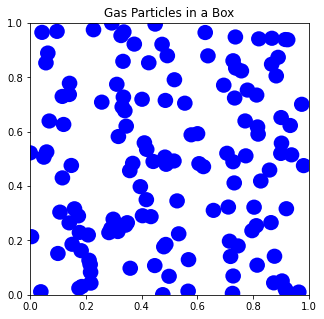

In [11]:
#@title Setting Up a Box { run: "auto", vertical-output: true }

n_particles = 136 #@param {type:"slider", min:2, max:500, step:1}
r = np.random.random((2,n_particles))
ids = np.arange(n_particles)
v = np.zeros((2,n_particles))
ids_pairs = np.asarray(list(combinations(ids,2)))

def rad(r, v, id_pairs, ts, d_cutoff):
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    # Initial State
    rs[0] = r.copy()
    vs[0] = v.copy()
    return rs, vs

radius = 0.028 #@param {type:"slider", min:0.001, max:0.05, step:0.001}
ts = 1

rs, vs = rad(r, v, ids_pairs, ts, d_cutoff=2*radius) #ts effects starting position
fig, ax = plt.subplots(1,1,figsize=(5,5))

xcir, ycir = rs[0][0],rs[0][1]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xcir,ycir)]
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.title("Gas Particles in a Box")


# 2. Deriving Equations

I would like to preface this entire section with this: I am not a physicist so take everything I say with a grain or two of salt. Everything here is my understanding of fairly complicated topics, so if you're interesting in learning more I highly suggestion you look into it yourself. 

## 2.1 Assumed Values

Add stuff

## 2.2 Deriving the Equation for Elastic Collisions

Elastic collisions are the result of two bodies(in this case gas particles) interacting and maintaining the same kinetic energy. As an example, if two balls floating in space bumped into each other with an inital $K$ of $3kJ$. If their interaction loses no $K$(wherein no energy is lost through heat, noise, ect.), this would be an elastic collision. 

\\

If we have two particles both with an inital $V_i$, we need to find their final $V_f$.


# 3. The First Animation

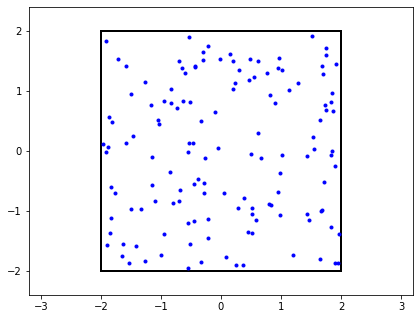

In [12]:
#@title The Animation { vertical-output: true }

class ParticleBox:

    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 bounds = [-2, 2, -2, 2],
                 radius = radius,
                 M = 0.01):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.radius = radius
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
        # positions
        self.state[:, :2] += dt * self.state[:, 2:]

        # collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.radius)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocity
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 

        # check for crossing boundary
        wall_x1 = (self.state[:, 0] < self.bounds[0] + self.radius)
        wall_x2 = (self.state[:, 0] > self.bounds[1] - self.radius)
        wall_y1 = (self.state[:, 1] < self.bounds[2] + self.radius)
        wall_y2 = (self.state[:, 1] > self.bounds[3] - self.radius)

        self.state[wall_x1, 0] = self.bounds[0] + self.radius
        self.state[wall_x2, 0] = self.bounds[1] - self.radius

        self.state[wall_y1, 1] = self.bounds[2] + self.radius
        self.state[wall_y2, 1] = self.bounds[3] - self.radius

        self.state[wall_x1 | wall_x2, 2] *= -1
        self.state[wall_y1 | wall_y2, 3] *= -1

np.random.seed(0)
init_state = -0.5 + np.random.random((n_particles, 4))
init_state[:, :2] *= 3.9

box = ParticleBox(init_state, radius=radius)
dt = 1. / 30 # 30fps

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))

particles, = ax.plot([], [], 'bo', ms=6)

rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

def init():
    """initialize animation"""
    global box, rect
    particles.set_data([], [])
    rect.set_edgecolor('none')
    return particles, rect

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig
    box.step(dt)

    ms = int(fig.dpi * 2 * box.radius * fig.get_figwidth()
             / np.diff(ax.get_xbound())[0])
    
    rect.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])
    particles.set_markersize(ms)
    return particles, rect

anim = animation.FuncAnimation(fig, animate, frames=600,
                              interval=10, blit=True, init_func=init)
anim


# 4. Adding Temperature